# Assignment 2: sentiment analysis of SUTD Reddit
**Assignment due 21 March 11:59pm**

Welcome to the second assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned. 

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output and a labeled dataset which you create in the assignment will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster to solve and test the assignment.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 150 points for this assignment.

**ChatGPT policy** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [10]:
# # Installing all required packages
# # Note: Do not add to this list.
# # ----------------
# ! pip install transformers[torch]==4.37.2
# ! pip install datasets==2.17.1
# ! pip install seaborn==0.13.2
# ! pip install pyarrow==15.0.0
# ! pip install scikit-learn==1.4.0
# ! pip install emoji==0.6.0
# ! pip install accelerate==0.27.2
# # ----------------

In [11]:
# Importing all required packages
# ----------------
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
# ----------------

In [12]:
%matplotlib inline


# Sentiment analysis

Sentiment analysis is a natural language processing technique that identifies the polarity of a given text. There are different flavors of sentiment analysis, but one of the most widely used techniques labels data into positive, negative and neutral. We have already encountererd sentiment analysis in the hands-on sessions.

In this assignment, you will conduct sentiment analysis on posts and comments from the SUTD subreddit. You will run experiments with pre-trained sentiment models, evaluate their performance and simulate improving the model by re-training it with newly annotated data. 


In [13]:
# Load SUTD subreddit data set as dataframe
# posts and comments have been downloaded from https://www.reddit.com/r/sutd/

df_submissions = pd.read_parquet('reddit_submissions.parquet.gzip').set_index("Id")
df_comments = pd.read_parquet('reddit_comments.parquet.gzip').set_index("CommentId")

In [14]:
#Let's have a look at the data. The data schema is as follows.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time

# Comments
# CommentId - unique id for comment
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time
# Id - unique id for submission on which the comment was posted

# See the Reddit API documentation for details https://www.reddit.com/dev/api/
df_submissions

,Title,Upvotes,Created
Id,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35
zzxqop,Happy New Year!,339,2022-12-31 16:26:57
rbe5cz,Happy finals!,319,2021-12-08 00:45:22
zlci46,You know who you are,266,2022-12-14 00:46:23
...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34


In [15]:
df_comments

,Comment,CommentCreated,Id
CommentId,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop
...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4


You can read the SUTD reddit submissions in your web browser by navigating to 
https://www.reddit.com/r/sutd/comments/{Id}


### QUESTION: 
How easy is it to make sense of the submissions and comments? Is it easier to understand the posts when you read them in the browser? 
Explain why or why not (max 100 words)

**--- ADD YOUR SOLUTION HERE (5 points)---**

It is pretty challenging to make sense of the submission and comments as we only have an id that ties the comment back to the original post to determine the context of the original post. The comments seen from the database also does not show the relation of comments being in the same thread and help us determine if a comment is replying to another comment under the post, or to the post itself. The data also only shows the title of the post, and not the rest of the post's content. 

------------------------------


In [16]:
# QUESTION: Join the data frames into a joined data_frame 'df_reddit' which  contains both submissions and comments. 
# Each row should contain a submission paired with one associated comment. Comments that do not have a matching submission shall be dropped. The joined data frame should have the following schema.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time
# CommentId - unique id for comment, comment is posted for this submission
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time
#--- ADD YOUR SOLUTION HERE (5 points)---

# adding commentId in df_comments as a column 
df = df_comments.reset_index()

# merging both df on Id
df_reddit = pd.merge(df_submissions, df, on="Id", how="inner")
#------------------------------

In [17]:
# Print the first 10 rows of the joined data frame
df_reddit.head(10)

# Hint: submission will be duplicated as many times as there are comments

,Id,Title,Upvotes,Created,CommentId,Comment,CommentCreated
0,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29
1,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59
2,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01
3,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53
4,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21
5,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j54ub3e,"HEY, FUCK YOU",2023-01-20 12:15:41
6,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2hjzse,"Meanwhile me who has work on christmas eve, ch...",2023-01-01 09:44:48
7,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2i7d80,hahahaaha same,2023-01-01 14:48:55
8,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2m5mdr,f school man,2023-01-02 09:54:47
9,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j4fvc93,Same,2023-01-15 12:41:33


In [18]:
# Now let's run a pre-trained sentiment analysis model on the submissions and comments
# A convenient way to execute pre-trained models for standard tasks are Huggingface pipelines
# Here we run a standard sentiment analysis pipeline on the first ten submission titles 
sentiment_pipeline = pipeline("sentiment-analysis", device=0)
print(sentiment_pipeline(list(df_submissions['Title'][:10])))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


[{'label': 'POSITIVE', 'score': 0.9927398562431335}, {'label': 'NEGATIVE', 'score': 0.7195630073547363}, {'label': 'POSITIVE', 'score': 0.999868631362915}, {'label': 'POSITIVE', 'score': 0.9998632669448853}, {'label': 'POSITIVE', 'score': 0.9992561936378479}, {'label': 'POSITIVE', 'score': 0.5723460912704468}, {'label': 'NEGATIVE', 'score': 0.9995667338371277}, {'label': 'POSITIVE', 'score': 0.9972499012947083}, {'label': 'NEGATIVE', 'score': 0.9956018924713135}, {'label': 'NEGATIVE', 'score': 0.9826338887214661}]


In [19]:
# QUESTION: Complete the function 'analyse_sentiment' which takes a data frame, a Huggingface sentiment pipeline object 
# and a target column name and adds two columns 'Label' and 'Score' to the data frame in place.
# pass the provided tokenizer arguments to the pipeline
# The new columns should contain the sentiment labels and scores, respectively.


def analyse_sentiment(df, sentiment_pipeline, column):
    tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':128,}
#--- ADD YOUR SOLUTION HERE (10 points)---
    res = sentiment_pipeline(list(df[column]), **tokenizer_kwargs)
    labels, scores = [], []
    for result in res:
        labels.append(result["label"])
        scores.append(result["score"])
    df["Labels"] = labels
    df["Scores"] = scores

#------------------------------

In [20]:
# add sentiment labels and scores to the submissions and comments dataframes
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')


In [21]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Labels,Scores
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POSITIVE,0.992740
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEGATIVE,0.719563
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POSITIVE,0.999869
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POSITIVE,0.999863
zlci46,You know who you are,266,2022-12-14 00:46:23,POSITIVE,0.999256
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEGATIVE,0.998578
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,POSITIVE,0.845063
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POSITIVE,0.967637


In [22]:
# display dataframe 
df_comments

,Comment,CommentCreated,Id,Labels,Scores
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,NEGATIVE,0.881345
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,POSITIVE,0.987902
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,NEGATIVE,0.999672
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEGATIVE,0.992340
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEGATIVE,0.696361
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POSITIVE,0.999398
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,POSITIVE,0.619020
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,POSITIVE,0.651068


### QUESTION: 
From a first inspection of the results, what problems can you see with our current sentiment analysis?
What model is used for the sentiment analysis and how was is trained?

**--- ADD YOUR SOLUTION HERE (5 points) ---**

The sentiment analysis is not very acurate as it miscategorised some comments and title as Negative when they carry positive sentiments and vice versa. The data also lacks a "Neutral" label for comments and titles that do not carry positive nor negative sentiments, hence these comments and titles are miscategorised as well. The model also categorises the comments based on the Title, without taking into account the context of the post's title. 

The model used was distilbert/distilbert-base-uncased-finetuned-sst-2-english which used stanfordnlp/sst2 dataset that consists of data that are carry binary labels "Positive" or "Negative".

------------------------------


In [23]:
# QUESTION: Update the sentiment pipeline to use the model "finiteautomata/bertweet-base-sentiment-analysis" from Huggingface
# The model should output three classes: 'POS', 'NEG', 'NEU'
# Store the model name in separate variable "model_name"

#--- ADD YOUR SOLUTION HERE (5 points) ---
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
sentiment_pipeline = pipeline(task = "sentiment-analysis", model = model_name, device=0)
print(sentiment_pipeline(list(df_submissions['Title'][:10])))
#------------------------------


Device set to use mps:0


[{'label': 'POS', 'score': 0.9874617457389832}, {'label': 'NEU', 'score': 0.846713662147522}, {'label': 'POS', 'score': 0.9924977421760559}, {'label': 'POS', 'score': 0.992440938949585}, {'label': 'NEU', 'score': 0.6117529273033142}, {'label': 'POS', 'score': 0.6473573446273804}, {'label': 'NEG', 'score': 0.8963016271591187}, {'label': 'POS', 'score': 0.9389117956161499}, {'label': 'NEU', 'score': 0.97343510389328}, {'label': 'NEU', 'score': 0.9616515636444092}]


### QUESTION: 

Explain why this model is better suited for the task (max 100 words).

**--- ADD YOUR SOLUTION HERE (5 points) ---**

This model is able to more appropriately categorise the comments as there are comments that carry a neutral sentiment which this model is able to categorise. Comments that are simply stating some facts or have no tone overall can now be categorised as neutral.

------------------------------


In [24]:
# re-run the sentiment analysis of submissions and comments
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')


In [25]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Labels,Scores
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POS,0.987462
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEU,0.846714
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POS,0.992498
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POS,0.992441
zlci46,You know who you are,266,2022-12-14 00:46:23,NEU,0.611753
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEG,0.825060
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,NEU,0.963418
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POS,0.675288


In [26]:
# display dataframe 
df_comments

,Comment,CommentCreated,Id,Labels,Scores
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,POS,0.764860
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,NEU,0.932431
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,POS,0.808931
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEU,0.962069
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEU,0.972654
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POS,0.968053
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,NEG,0.874083
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,NEG,0.901180


In [27]:
# QUESTION: What is the time frame covered by the data set, i.e. what is the earliest time of a submission or comment and what is the most recent time?
# Find the earliest and latest timestamp and print them
#--- ADD YOUR SOLUTION HERE (8 points)---
earliest_post_timestamp = min(df_submissions["Created"])
latest_post_timestamp = max(df_submissions["Created"])

earliest_comment_timestamp = min(df_comments["CommentCreated"])
latest_comment_timestamp = max(df_comments["CommentCreated"])

print(f"Earliest timestamp: {earliest_comment_timestamp if earliest_comment_timestamp < earliest_post_timestamp else earliest_post_timestamp}")
print(f"Latest timestamp: {latest_comment_timestamp if latest_comment_timestamp > latest_post_timestamp else latest_post_timestamp}")
#------------------------------

Earliest timestamp: 2017-11-12 17:06:27
Latest timestamp: 2024-01-24 03:39:32


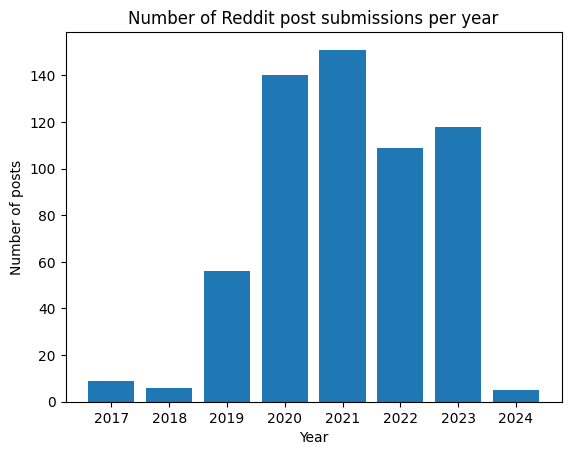

In [28]:
# QUESTION: How did the volume of posts on the SUTD subreddit change over the years?
# Create a bar chart diagram that plots the number of submissions per year on the y-axis and the year on the x-axis.

#--- ADD YOUR SOLUTION HERE (8 points) ---
years = {}

for entry in df_submissions["Created"]:
    submission_year = entry.year
    years[submission_year] = years.get(submission_year, 0) + 1

plt.bar(years.keys(), years.values())
plt.title("Number of Reddit post submissions per year")
plt.xlabel("Year")
plt.ylabel("Number of posts")
plt.show()
#------------------------------

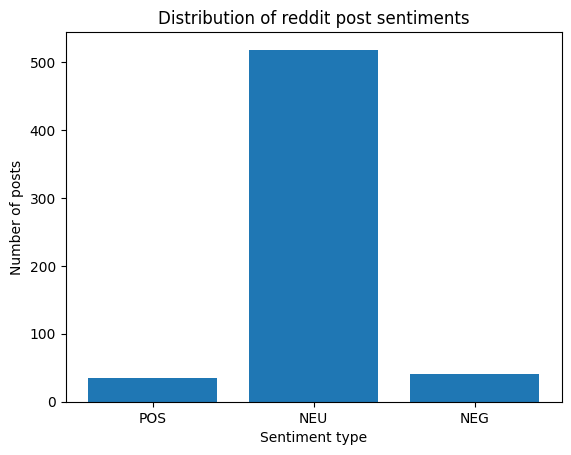

In [29]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment?
# Create a bar chart diagram that plots the number of submissions on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---
labels = {}

for label in df_submissions["Labels"]:
    labels[label] = labels.get(label, 0) + 1

plt.bar(labels.keys(), labels.values())
plt.title("Distribution of reddit post sentiments")
plt.xlabel("Sentiment type")
plt.ylabel("Number of posts")
plt.show()
#------------------------------

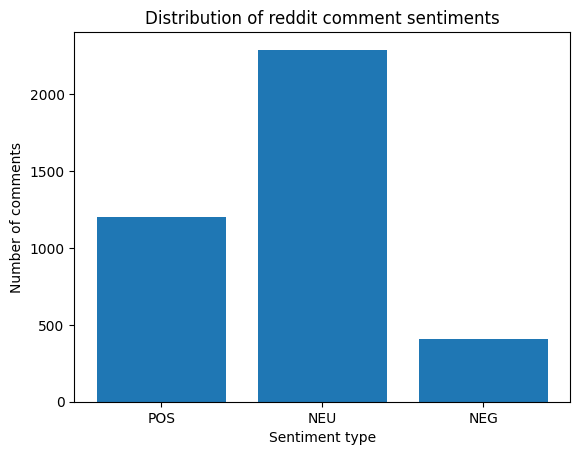

In [30]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment for comments?
# Create a bar chart diagram that plots the number of comments on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---
comment_labels = {}

for label in df_comments["Labels"]:
    comment_labels[label] = comment_labels.get(label, 0) + 1

plt.bar(comment_labels.keys(), comment_labels.values())
plt.title("Distribution of reddit comment sentiments")
plt.xlabel("Sentiment type")
plt.ylabel("Number of comments")
plt.show()
#------------------------------

In [31]:
# QUESTION: combine submission titles and comments for the time period from 2021 until today into one data frame.
# The resulting data frame 'df_text' should have the following schema

# Id - unique id of the comment or the submissions, this column is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML

#--- ADD YOUR SOLUTION HERE (10 points)---
df_comments_timeframe = df_comments[df_comments["CommentCreated"].dt.year >= 2021].reset_index().loc[:, ["CommentId", "Comment", "CommentCreated", "Labels"]]
df_comments_timeframe = df_comments_timeframe.rename(columns={"CommentId": "Id", "Comment": "Text", "CommentCreated": "Created", "Labels": "Label"})
df_submissions_timeframe = df_submissions[df_submissions["Created"].dt.year >= 2021].reset_index().loc[:, ["Id", "Title", "Created", "Labels"]]
df_submissions_timeframe = df_submissions_timeframe.rename(columns={"Title": "Text", "Created": "Created", "Labels": "Label"})

df_text = pd.concat([df_comments_timeframe, df_submissions_timeframe], axis=0, ignore_index=True)
#------------------------------

In [32]:
# inspect the resulting data frame
df_text

,Id,Text,Created,Label
0,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,POS
1,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,NEU
2,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,POS
3,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,NEU
4,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,NEU
...,...,...,...,...
2911,lkegot,Work/Study balance,2021-02-15 14:13:52,NEU
2912,l94o87,Poly to SUTD cross course admission: is it pos...,2021-01-31 04:38:39,NEU
2913,l8mdqm,[Uni] Thinking of cancelling placing in SUTD a...,2021-01-30 14:05:56,NEU
2914,kp0zuf,HASS mod recommendation,2021-01-02 17:02:09,NEU


In [33]:
# QUESTION: sort the data frame by date time descending and save it in the same variable

#--- ADD YOUR SOLUTION HERE (3 points)---
df_text = df_text.sort_values(by = "Created", ascending = True)
#------------------------------

In [34]:
# inspect the resulting data frame
df_text

,Id,Text,Created,Label
1028,ghq4jty,woww thank you so much for taking the time to ...,2021-01-01 16:06:17,POS
2915,kovm76,I am currently still in highschool (indo) and ...,2021-01-02 10:52:03,NEU
2914,kp0zuf,HASS mod recommendation,2021-01-02 17:02:09,NEU
2590,kpde9d,Subjects in Year 1,2021-01-03 04:13:53,NEU
1917,ghwf0at,Yes. I am indoneisan myself. In fact we have a...,2021-01-03 04:32:08,NEU
...,...,...,...,...
212,kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",2024-01-23 13:34:29,POS
213,kj6z72l,"I see, wishing you all the best for the result...",2024-01-23 13:50:05,POS
214,kj74anz,"Thks! Hope you have a great FEAST II, all the ...",2024-01-23 14:25:22,POS
137,kjau765,Hi! I would like to ask if it is possible for ...,2024-01-24 03:38:13,NEU


In [35]:
# save data frame to csv
df_text.to_csv("reddit.csv")


Download the csv file and open it in a spreadsheet application or text editor. 

Inspec the first 10-20 entries in the list to get a feeling for the data domain.

### QUESTION: 
Write a short labeling guide for annotating the SUTD reddit data with sentiment labels. 
You can write the labeling guide in a bullet point format and should have 5-10 points.

**--- ADD YOUR SOLUTION HERE (10 points)---**

#### Positive Labeling Criteria
- Text labelled as positive should have expressions of gratitute and appreciation
- Sharing of positive experiences
- Helpful and supportive responses with an overall positive an encouraging tone

#### Negative Labeling Criteria
- Text that show signs of frustrations or carry a generally negative tone
- Sarcastic or critical comments
- Complaints and rude behaviours

#### Neutral Labeling Criteria
- Text that are open ended or asking questions
- General process descriptions without any opinions
- Factual-based and balanced statements
- Text that are gibberish or just contain a single link or have been deleted or removed

------------------------------


## Label the data
Add a new column 'HumanLabel' to the csv file and label the 500 most recent entries, including the first 10-20 you inspected to create the label guide, using a spreadsheet application (Excel, Google Docs, Numbers) or just a text editor. 

### QUESTION: 
What were some of the ambiguous cases or corner cases you encountered?
List 3-5 issues

**--- ADD YOUR SOLUTION HERE (30 points)---**

Some corner cases include deleted posts and comments. Certain posts and comments have been deleted, either by the user or the system and the data entry is not cleared away. Instead, the text shows [deleted]. This is interpreted as a neutral text by the model, which is an approrpriate label. However, these data entries should be removed instead as they do not provide any value and can be imperative to the model's training. Some example would be text with ID "gvhp9iw" and "gq7n0wp"

A similar corner case would be for posts and comments that are removed. Likewise, these text show [removed], when the data entry should be removed instead. An example case would be for ID "gokbmfp", "gokbupc" and "gq7n0wp"

Some text also include some weird text, likely leftover code strings after data extraction. An example would be in the text with ID "gwirxw8" and "k837l1p". This text contained the following string "&#x200B;", which does not carry any inherent meaning. However, with some contextual clues, we can determine that the user was most likely replying to an earlier comment in the second half of the text. These information are not included in the text, hence the full context of the text could not be retrieved by the model

There are also sarcastic comments that can be interpreted as both neutral, positive and negative. An example would be text with ID "gjx3hvo". In this comment, the user said "There will be a ceremony where the sorting hat chooses your pillar.". While the exact comment/post the user was replying to is not known, we can assume that it was likely another user asking for some clarification on the pillar selection process. This comment is very sarcastic and it does not help the user who asked the question at all, which makes it a negative comment. However, it is not a harmful comment and it could be argued that it was just the user's attempt at cracking a lighthearted joke, which then makes it a positive comment. Hence, these cases are ambigious and it's labelling depends on the degree of humour of the labeler. 

------------------------------


Upload your 500 labeled instances as **reddit_labeled.csv** to JupyterLab.

## Evaluate
Compare your human-corrected labels with the original predicted labels.

In [36]:
# 
# QUESTION: Read the 500 labeled rows from the CSV file into a dataframe "df_labeled". 
# The data frame should have this schema.

# Id - unique id of the comment or the submissions, Id is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML
# HumanLabel - manually reviewed 'gold sentiment label'

#--- ADD YOUR SOLUTION HERE (5 points)---

df_labeled = pd.read_csv('reddit_labeled_jinchou_chua.csv')
df_labeled = df_labeled.drop("Unnamed: 0", axis = 1)
#------------------------------


In [37]:
# check the data was loaded correctly
df_labeled

,Id,Text,Created,Label,HumanLabel
0,kjaudx2,Unfortunately no and I don’t foresee it to cha...,24/1/24 3:39,NEG,NEU
1,kjau765,Hi! I would like to ask if it is possible for ...,24/1/24 3:38,NEU,NEU
2,kj74anz,"Thks! Hope you have a great FEAST II, all the ...",23/1/24 14:25,POS,POS
3,kj6z72l,"I see, wishing you all the best for the result...",23/1/24 13:50,POS,POS
4,kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",23/1/24 13:34,POS,NEU
...,...,...,...,...,...
495,jlsz8pd,Entered having not taken physics since sec 2 b...,27/5/23 9:33,NEU,NEU
496,jlsjszp,Fun if you join fifth rows that you like. Yeah...,27/5/23 5:57,POS,NEU
497,jls9yp6,"If you have access to a gpu cloud, anything goes",27/5/23 4:04,POS,NEU
498,jls8deo,OOo i see!! Any medical examination requiremen...,27/5/23 3:48,NEU,NEU


In [38]:
# split the labeled data into two chunks, ordered by time
df_labeled.sort_values('Created', ascending=True, inplace=True)

df_labeled1 = df_labeled[:250]
df_labeled2 = df_labeled[250:]

In [39]:
# check that the each split is 250 instances and that they don't overlap
df_labeled1


,Id,Text,Created,Label,HumanLabel
48,kfubv9y,https://www.reddit.com/r/sutd/s/71Bv8Bg6Xr,1/1/24 15:40,NEU,NEU
49,18vqvy4,Seeking Scholarship Info and Funding Guidance,1/1/24 6:36,NEU,NEU
452,jmgqich,let's be friends!! :),1/6/23 11:49,POS,POS
451,13xltzi,SS ILP Experience,1/6/23 16:16,NEU,NEU
457,jmffwnd,count me in!!!!,1/6/23 2:54,POS,NEU
...,...,...,...,...,...
197,jxhbt9b,any laptop works if going csd. only maybe arch...,23/8/23 23:07,NEU,NEU
1,kjau765,Hi! I would like to ask if it is possible for ...,24/1/24 3:38,NEU,NEU
0,kjaudx2,Unfortunately no and I don’t foresee it to cha...,24/1/24 3:39,NEG,NEU
87,182vwyh,Exchange at SUTD,24/11/23 16:28,NEU,NEU


In [40]:
df_labeled2


,Id,Text,Created,Label,HumanLabel
55,keq4c28,Hi! So what does the exam covers?,24/12/23 10:10,NEU,NEU
54,keq4e9k,Hi! So what does the uee covers?,24/12/23 10:11,NEU,NEU
342,jpdhkm3,Enter through EASE and access outlook 365 on t...,24/6/23 18:05,NEU,NEU
341,jpdivgn,If u r sgporean no need chest x ray,24/6/23 18:15,NEU,NEU
346,jpbhocg,Current SUTD student here!\n\nI'm happy to hel...,24/6/23 6:02,POS,POS
...,...,...,...,...,...
282,jr8vvvo,20 - successful appeal outcome \n17 - unsucces...,9/7/23 6:04,NEU,NEU
281,jr93tje,"utterly devastated, got a good decent rp, they...",9/7/23 7:47,NEG,NEG
222,jveme8g,ur sutd email is just ur first name_lastname@m...,9/8/23 5:33,NEU,NEU
179,jzso3ue,"Good day sir, Im taking my Feast test 2 this c...",9/9/23 10:01,NEU,NEU


In [41]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 1. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled1["Label"], df_labeled1["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.82      0.31      0.45        29
         NEU       0.84      0.95      0.89       164
         POS       0.80      0.77      0.79        57

    accuracy                           0.83       250
   macro avg       0.82      0.68      0.71       250
weighted avg       0.83      0.83      0.82       250



In [42]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 2. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled2["Label"], df_labeled2["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.94      0.48      0.64        31
         NEU       0.74      0.93      0.83       148
         POS       0.78      0.55      0.64        71

    accuracy                           0.76       250
   macro avg       0.82      0.65      0.70       250
weighted avg       0.78      0.76      0.75       250



## Retrain sentiment model

Now let us use the data in df_labeled1 to try improve the sentiment classifier.
Train the Huggingface model you have chosen with the 250 examples and your human gold labels.

Start by converting the data from data frames into a 2 Huggingface datasets. 
- dataset1 : a Huggingface dataset object which includes the data from dataframe df_labeled1
- dataset2 : a Huggingface dataset object which includes the data from dataframe df_labeled2


In each dataset, there should be the following fields
- text : the text of the reddit submission or comment
- label: the human gold label, encoded as integer

With these dataset we will simulate the process of improving a model in production. Dataset1 is simulating a batch of data which we observed in production, annotated and then use to improve the model. We evaluate the change on the new training data and on the next batch of production data, simulated by dataset2.


In [43]:
def convert_label(df, pipeline):
    # drop predicted label column
    df = df.drop("Label", axis=1)
    # convert string labels to integers as column 'label' using the sentiment pipeline config
    label_id_mapping = lambda label: pipeline.model.config.label2id[label]
    df['label'] = df['HumanLabel'].apply(label_id_mapping)
    return df

df_labeled1 = convert_label(df_labeled1, sentiment_pipeline)
df_labeled2 = convert_label(df_labeled2, sentiment_pipeline)

In [44]:
# QUESTION: Convert the text and human labels from the data frame to a huggingface dataset format
# create a huggingface 'dataset1' from data frame 'df_labeled1' and 'dataset2' from data frame 'df_labeled2' 
#
# each dataset has the following fields
# text : the text of the reddit submission or comment
# label: the human gold label, encoded as integer

#--- ADD YOUR SOLUTION HERE (5 points)---
dataset1 = Dataset.from_pandas(df_labeled1[["Text", "label"]])
dataset1 = dataset1.rename_column(original_column_name= "Text", new_column_name= "text")

dataset2 = Dataset.from_pandas(df_labeled2[["Text", "label"]])
dataset2 = dataset2.rename_column(original_column_name= "Text", new_column_name= "text")

#------------------------------


In [45]:
# inspect the first example
dataset1[0]

{'text': 'https://www.reddit.com/r/sutd/s/71Bv8Bg6Xr',
 'label': 1,
 '__index_level_0__': 48}

In [46]:
# load tokenizer and tokenize data set
# 
# QUESTION: Load the required tokenizer from Huggingface into a variable 'tokenizer'
# Then tokenize 'dataset1' into 'tokenized_dataset1' and 'dataset2' into 'tokenized_dataset2'
# Use the Huggingface libraries. Remember that we stored the model name in a variable "model_name"

# helper function for tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=128)

#--- ADD YOUR SOLUTION HERE (5 points)---
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_dataset1 = dataset1.map(tokenize_function, batched=True)
tokenized_dataset2 = dataset2.map(tokenize_function, batched=True)
#------------------------------



Map: 100%|██████████| 250/250 [00:00<00:00, 4518.17 examples/s]


In [47]:
# load Hugging model for classification initialized with the sentiment model you have chosen

#--- ADD YOUR SOLUTION HERE (3 points)---
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
#------------------------------
# Hint: make sure your model corresponds to your tokenizer

In [48]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [49]:

#
# QUESTION: configure the training parameters using the Hugginface TrainingArguments class
# - set the output directory to "finetuning-reddit"
# - do not report training metrics to an external experiment tracking service
# - learning rate to 2e-5, 
# - set weight decay to 0.01
# - set logging_steps to 10,
# - set evaluation_strategy to "steps",
# - set epochs to 3


#--- ADD YOUR SOLUTION HERE (3 points)---
training_args = TrainingArguments(
    output_dir="finetuning-reddit",
    report_to=None,
    evaluation_strategy="steps",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=3,
    logging_steps=10)
#------------------------------



/Users/jin/Documents/GitHub/EC_Calculator_App/venv/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [50]:
# initialize trainer
# train on the split dataset1
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset1,
    eval_dataset=tokenized_dataset2,
    compute_metrics=compute_metrics,
)

In [51]:
# Evaluate on dataset1 set before training 
predictions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset1['label']))


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: chuajinchou (chuajinchou-singapore-university-of-technology-and-desig) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


              precision    recall  f1-score   support

           0       0.82      0.31      0.45        29
           1       0.84      0.95      0.89       164
           2       0.80      0.77      0.79        57

    accuracy                           0.83       250
   macro avg       0.82      0.68      0.71       250
weighted avg       0.83      0.83      0.82       250



In [52]:
# Evaluate on dataset2 set before training 
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


              precision    recall  f1-score   support

           0       0.94      0.48      0.64        31
           1       0.74      0.93      0.83       148
           2       0.78      0.55      0.64        71

    accuracy                           0.76       250
   macro avg       0.82      0.65      0.70       250
weighted avg       0.78      0.76      0.75       250



In [53]:
# train the model
train_output = trainer.train()

Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
10,0.396800,0.427145,0.001400,0.828000,0.851047,0.828000,0.832859
20,0.483600,0.431988,0.001400,0.816000,0.847149,0.816000,0.822496
30,0.297000,0.358689,0.001400,0.880000,0.887712,0.880000,0.882526
40,0.110200,0.369302,0.001400,0.876000,0.873482,0.876000,0.872926
50,0.195300,0.419685,0.001400,0.880000,0.882457,0.880000,0.875356
60,0.172900,0.491369,0.001400,0.852000,0.880336,0.852000,0.859218
70,0.111500,0.583063,0.001400,0.824000,0.866201,0.824000,0.834089
80,0.131800,0.522726,0.001400,0.844000,0.873004,0.844000,0.851670
90,0.122900,0.488558,0.001400,0.856000,0.876694,0.856000,0.861618


In [54]:
# Evaluate on dataset1, i.e the training set again
preditions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(preditions.predictions.argmax(-1), dataset1['label']))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       1.00      0.99      0.99       186
           2       0.96      1.00      0.98        53

    accuracy                           0.99       250
   macro avg       0.96      0.97      0.96       250
weighted avg       0.99      0.99      0.99       250



In [55]:
# Evaluate on dataset2 set i.e. the test set again
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


              precision    recall  f1-score   support

           0       0.81      0.81      0.81        16
           1       0.86      0.95      0.90       167
           2       0.86      0.64      0.74        67

    accuracy                           0.86       250
   macro avg       0.84      0.80      0.82       250
weighted avg       0.86      0.86      0.85       250



### QUESTION: 
Has the model improved performance on the first batch of data? Does the model generalize well to the next batch of data?
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points)---**

Overall, the accuracy of the model has improved greatly, with the accuracy of training data improving from 0.83 to 0.99 and the accuracy of the validation data improving from 0.76 to 0.86. Purely based on accuracy, the model somewhat generalizes well to the next batch of data as the accuracy of the validation dataset is still very high at 0.86.

Yes, there are signs of overfitting in the evaluation scores. From the computed metrics, we can see that the training loss has improved after training yet the validation loss has been increasing. These are hallmark indications of overfitting model as this shows that the model is not generalising well with new unseen data, yet the training loss is improving. 

------------------------------


### QUESTION: 
Is the model good enough to be used for practical applications?
Given the results you have so far, what additional measures would you recommend to continuously improve the SUTD reddit sentiment classifier? What other functionalities beyond sentiment could be useful? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**

No, this model is not good enough to be used for practical applications. The precision for detecting comments with a negative sentiment is too low for it to be practical.

From the dataset, we can determine that there is an **uneven class distribution**, where there are only a handful of rows with a negative sentiment, while a large percentage of the data have a neutral sentiment. Data should be consistently updated with new human labeled comments and posts, each following a strict labeling guideline. A data centric approach should also be adopted wherein more comments and posts with negative sentiments should be added to the training dataset to balance out the poor distribution of the classes. 

A functionality could be question detection for detecting unanswered posts that are asking common questions. A RAG pipeline could be used to connect a depository of verified documents with a LLM chatbot. When the system detects that a post has been unanswered for a certain duration, the LLM chatbot could respond to the question automatically, so as to service the community while not infringing upon the community's engagement. 

------------------------------


# End

This concludes assignment 2.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** and the **text file reddit_labeled_STUDENT_NAME.csv** via github.


1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_02_STUDENT_NAME.ipynb and reddit_labeled_STUDENT_NAME.csv where STUDENT_NAME is your name in your SUTD email address.  
4. Push the submission files to your repo 
5. Submit the link to the repo via eDimensions

Example:<br/>
Email: michael_tan@mymail.sutd.edu.sg<br/>
STUDENT_NAME: michael_tan<br/>
Submission file name: assignment_02_michael_tan.ipynb



**Assignment due 21 March 2025 11:59pm**

